# Lecture 10 - Decision Trees

***
##### CS 434 - Dating Mining and Machine Learning
##### Oregon State University-Cascades
***

<img src=https://i.vas3k.ru/7w3.jpg width="500">

## <img src="https://img.icons8.com/color/32/000000/fork-lift.png"/> Load packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pydotplus import graph_from_dot_data
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import Image
%matplotlib inline

### <img src="https://img.icons8.com/color/24/000000/cosine.png"/> Helper function for graphing our results

In [0]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

## <img src="https://img.icons8.com/color/32/000000/accept-database.png"/> Prepare a dataset

### <img src="https://img.icons8.com/color/32/000000/database-restore.png"/>  Load the data


Load the Iris dataset from scikit-learn. 

In [0]:
# load the dataset
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
print(df)

     sepal length (cm)  sepal width (cm)  ...  petal width (cm)  target
0                  5.1               3.5  ...               0.2     0.0
1                  4.9               3.0  ...               0.2     0.0
2                  4.7               3.2  ...               0.2     0.0
3                  4.6               3.1  ...               0.2     0.0
4                  5.0               3.6  ...               0.2     0.0
..                 ...               ...  ...               ...     ...
145                6.7               3.0  ...               2.3     2.0
146                6.3               2.5  ...               1.9     2.0
147                6.5               3.0  ...               2.0     2.0
148                6.2               3.4  ...               2.3     2.0
149                5.9               3.0  ...               1.8     2.0

[150 rows x 5 columns]


### <img src="https://img.icons8.com/color/32/000000/search-property.png"/>  Examine the data

The classes are integer labels where 
* 0=Iris-Setosa
* 1=Iris-Versicolor
* 2=Iris-Virginica

In [0]:
# data size
X = iris.data
print('X shape', X.shape)
y = iris.target
print('y shape', y.shape)
print('Class labels:', np.unique(y))

X shape (150, 4)
y shape (150,)
Class labels: [0 1 2]


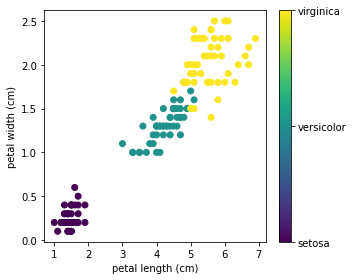

In [0]:
# compare two features
x_index = 2   # petal length
y_index = 3   # petal width

formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])

plt.figure(figsize=(5, 4))
plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])

plt.tight_layout()
plt.show()

### <img src="https://img.icons8.com/color/32/000000/hashtag-activity-feed-2.png"/>  Get attributes and class labels


In [0]:
# consider only the third column of the petal length, and 
# the fourth column of petal width of the flower. 
X = iris.data[:, [2, 3]]
y = iris.target

### <img src="https://img.icons8.com/color/32/000000/split-files.png"/> Split into train and test sets

In this example, 70% is for training and 30% is for testing.

In [0]:
# hold out split with 30% data as test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

print('Label counts in y:', np.bincount(y))
print('Label counts in y_train:', np.bincount(y_train))
print('Label counts in y_test:', np.bincount(y_test))

Label counts in y: [50 50 50]
Label counts in y_train: [35 35 35]
Label counts in y_test: [15 15 15]


### <img src="https://img.icons8.com/color/32/000000/compare.png"/> Standardize the features

In [0]:
# standardize
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# needed for graphing
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# <img src="https://img.icons8.com/color/32/000000/genealogy.png"/> Decision trees

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch03/images/03_17.png width="1000">

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch03/images/03_18.png width="1000">

# <img src="https://img.icons8.com/color/32/000000/info--v1.png"/> Information gain

## Mutual information

In probability theory and information theory, the [mutual information](https://en.wikipedia.org/wiki/Mutual_information) (or *information gain*) of two random variables is a measure of the mutual dependence between the two variables. More specifically, it quantifies the "amount of information" (in units such as [shannons](https://en.wikipedia.org/wiki/Shannon_(unit)), commonly called bits) obtained about one random variable through observing the other random variable. 

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Entropy-mutual-information-relative-entropy-relation-diagram.svg/744px-Entropy-mutual-information-relative-entropy-relation-diagram.svg.png width="500">

The concept of mutual information is intricately linked to that of [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory) of a random variable, a fundamental notion in information theory that quantifies the expected "amount of information" held in a random variable.

## <img src="https://img.icons8.com/color/32/000000/cosine.png"/> Impurity indices

### <img src="https://img.icons8.com/color/32/000000/e.png"/> Entropy

The entropy is defined as
$$I_H(t) = - \sum_{i =1}^{C} p(i \mid t) \;log_2 \,p(i \mid t)$$

for all non-empty classes ($p(i \mid t) \neq 0$), where $p(i \mid t)$ is the proportion (or frequency or probability) of the samples that belong to class $i$ for a particular node $t$; $C$ is the number of unique class labels.

The entropy is therefore 0 if all samples at a node belong to the same class, and the entropy is maximal if we have an uniform class distribution. For example, in a binary class setting, the entropy is 0 if  $p(i =1 \mid t) =1$ or $p(i =0 \mid t) =1$. And if the classes are distributed uniformly with $p(i =1 \mid t) = 0.5$ and $p(i =0 \mid t) =0.5$ the entropy is 1 (maximal), which we can visualize by plotting the entropy for binary class setting below.


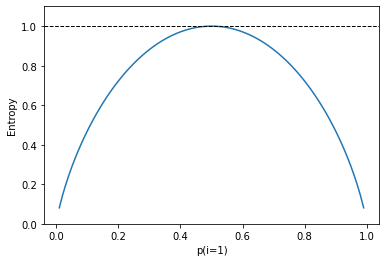

In [0]:
# entropy
def entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))
x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
plt.plot(x, ent)
plt.ylim([0,1.1])
plt.xlabel('p(i=1)')
plt.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylabel('Entropy')
plt.show()

### <img src="https://img.icons8.com/color/32/000000/g.png"/> Gini Impurity


Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.


$$I_G(t) =  \sum_{i =1}^{C}p(i \mid t) \big(1-p(i \mid t)\big)$$

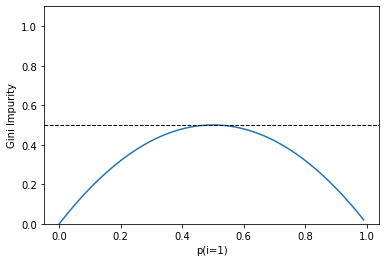

In [0]:
# gini impurity
def gini(p):
    return (p)*(1 - (p)) + (1-p)*(1 - (1-p))

x = np.arange(0.0, 1.0, 0.01)
plt.plot(x, gini(x))
plt.ylim([0,1.1])
plt.xlabel('p(i=1)')
plt.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
plt.ylabel('Gini Impurity')
plt.show()

### <img src="https://img.icons8.com/color/32/000000/cancel--v1.png"/> Misclassification Error



The misclassification error refer to the number of individual that we know that below to a category that are classified by the method in a different category.


$$I_M(t) =  1 - max\{{p_i}\}$$

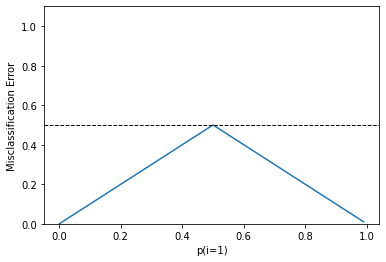

In [0]:
# misclassication error
def error(p):
    return 1 - np.max([p, 1-p])

x = np.arange(0.0, 1.0, 0.01)
err = [error(i) for i in x]
plt.plot(x, err)
plt.ylim([0,1.1])
plt.xlabel('p(i=1)')
plt.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
plt.ylabel('Misclassification Error')
plt.show()

### <img src="https://img.icons8.com/color/32/000000/compare.png"/> Comparison

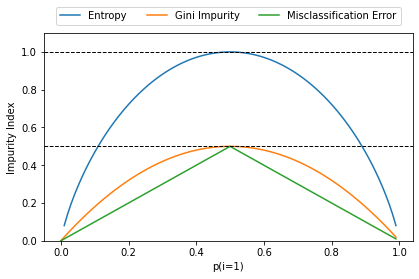

In [0]:
# graph and compare three impurities
fig = plt.figure()
ax = plt.subplot(111)

for i, lab in zip([ent, gini(x), err], 
                  ['Entropy', 'Gini Impurity', 'Misclassification Error']):
    line, = ax.plot(x, i, label=lab)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0,1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.tight_layout()
plt.show()

## <img src="https://img.icons8.com/color/32/000000/term.png"/> Information gain example

*Example given for binary splits.*

$$IG(D_{p}, a) = I(D_{p}) - \frac{N_{left}}{N_p} I(D_{left}) - \frac{N_{right}}{N_p} I(D_{right})$$

- $IG$: Information Gain
- $a$: feature to perform the split
- $N_p$: number of samples in the parent node
- $N_{left}$: number of samples in the left child node
- $N_{right}$: number of samples in the right child node
- $I$: impurity
- $D_{p}$: training subset of the parent node
- $D_{left}$: training subset of the left child node
- $D_{right}$: training subset of the right child node

# <img src="https://img.icons8.com/color/32/000000/forrst.png"/> Decision tree classifier

##  Overview

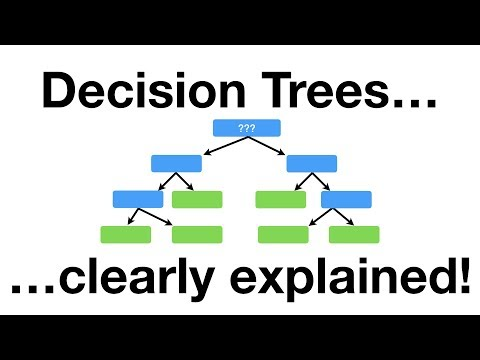

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('7VeUPuFGJHk')

### <img src="https://img.icons8.com/color/32/000000/serial-tasks.png"/>  Algorithm

1. Start at the root node as parent node
2. Split the parent node at the feature ***a*** to minimize the sum of the child node impurities (maximize information gain)
3. Assign training samples to new child nodes
3. Stop if leave nodes are pure or early stopping criteria is satisfied, else repeat steps 1 and 2 for each new child node

### <img src="https://img.icons8.com/color/32/000000/stop-squared.png"/> Stopping Rules

- a maximal node depth is reached
- splitting a note does not lead to an information gain

### <img src="https://img.icons8.com/color/32/000000/multiple-choice.png"/>  Criterion

* Splitting criterion: Information Gain (IG), sum of node impurities

* Objective function: Maximize IG at each split, eqiv. minimize the the impurity criterion


## <img src="https://img.icons8.com/color/32/000000/new-document.png"/> Example

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


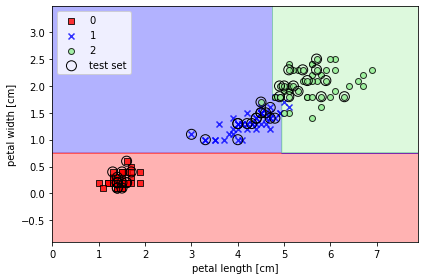

In [0]:
# DecisionTreeClassifer in sklearn
tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=4, 
                                    random_state=1)
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree_model,
                      test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### <img src="https://img.icons8.com/color/32/000000/inspect-code.png"/> Examine the tree

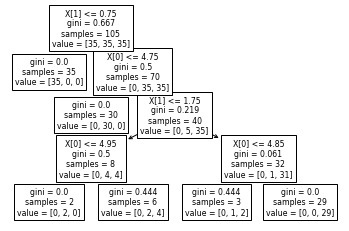

In [0]:
# show the tree
tree.plot_tree(tree_model)
plt.show()

### <img src="https://img.icons8.com/color/32/000000/rules.png"/> Explore the decision rules

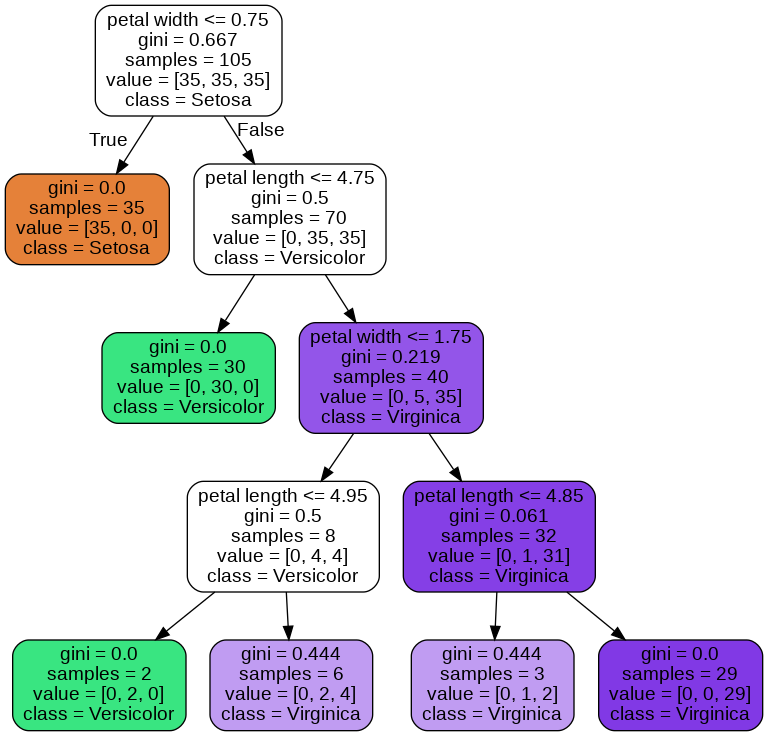

In [0]:
# graph the tree (and save image)
dot_data = export_graphviz(tree_model,
                           filled=True, 
                           rounded=True,
                           class_names=['Setosa', 
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length', 
                                          'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png')
Image(filename='tree.png', width=500) 